In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize

import os
import sys
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy.random as nr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


# Autocodificador Variacional

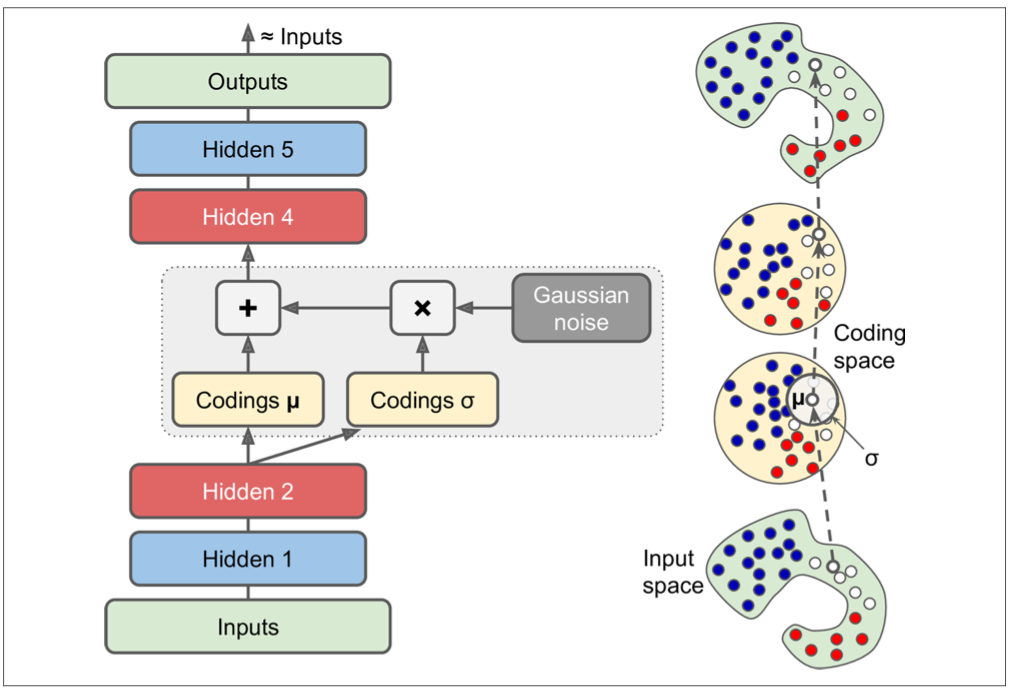

## Dataset MNIST

In [2]:
def get_mnist_data_loaders(batch_size):
    data_trafos = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        lambda x: x.view(28*28),
    ])
    train_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=True, transform=data_trafos)
    test_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=False, transform=data_trafos)
    print('Número de amostras no dataset (treino):', len(train_ds))
    print('Número de amostras no dataset (teste): ', len(test_ds))
    train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dloader =  DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_dloader, test_dloader

## O autocodificador

In [3]:
class VAE(nn.Module):
    def __init__(self, flatten_dim, latent_dim, intermediate_dim):
        super(VAE, self).__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc1  = nn.Linear(flatten_dim, intermediate_dim)
        self.fc21 = nn.Linear(intermediate_dim, latent_dim)
        self.fc22 = nn.Linear(intermediate_dim, latent_dim)
        self.fc3  = nn.Linear(latent_dim, intermediate_dim)
        self.fc4  = nn.Linear(intermediate_dim, flatten_dim)

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## A função de custo

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    
    # (1) cross-entropy
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # (2) Kullback–Leibler divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))

    return BCE + KLD


## Funções para treinamento e teste

In [5]:
class MyTrainer(ptt.DeepNetTrainer):
    
    def _do_optimize(self, X, Y):
        self.optimizer.zero_grad()
        X_recon, mu, logvar = self.model.forward(X)
        loss = self.criterion(X_recon, X, mu, logvar)
        loss.backward()
        self.optimizer.step()
        return X_recon, loss
    
    def _do_evaluate(self, X, Y):
        X_recon, mu, logvar = self.model.forward(X)
        loss = self.criterion(X_recon, X, mu, logvar)
        return X_recon, loss
    
    def predict_loader(self, data_loader):
        recons = []
        vmean  = []
        logvar = []
        for X, _ in data_loader:
            if self.use_gpu:
                X = Variable(X.cuda())
            else:
                X = Variable(X)
            x, mu, var = self.model.forward(X)
            recons.append(x.cpu())
            vmean.append(mu.cpu())
            logvar.append(var.cpu())
        recons = torch.cat(recons, 0)
        vmean = torch.cat(vmean, 0)
        logvar = torch.cat(logvar, 0)
        return recons, vmean, logvar

    
class MySaveImagesCallback(ptt.Callback):
    
    def __init__(self, base_filename, image_shape=(1, 28, 28)):
        self.base_fn = base_filename
        self.image_shape = image_shape
    
    def on_vbatch_end(self, epoch_num, batch_num, X, y, X_recon, loss):
        if batch_num == 0 and epoch_num % 2 == 0:
            n = min(X.size(0), 8)
            comparison = torch.cat([X.view(batch_size, *self.image_shape)[:n], 
                                    X_recon.view(batch_size, *self.image_shape)[:n]])
            save_image(comparison.data.cpu(), self.base_fn + '_{:03d}.png'.format(epoch_num), nrow=n)            



## Treinamento

In [6]:
trainIt = False
resetIt = False

n_epochs = 90
batch_size = 100
flatten_dim = 784
latent_dim = 2
intermediate_dim = 512

tra_loader, tst_loader = get_mnist_data_loaders(batch_size)
vae_net = VAE(flatten_dim, latent_dim, intermediate_dim)
optimizer = Adam(vae_net.parameters(), lr=1e-3)
if use_gpu:
    vae_net = vae_net.cuda()
    
# Callbacks
# ---------
images_bfn = '../../images/vae_mnist_recon'
if not os.path.exists('../../images/'):
    os.makedirs('../../images/')
model_bfn = '../../models/vae_mnist_01'
chkpt_cb = ptt.ModelCheckpoint(model_bfn, reset=resetIt, verbose=1)
print_cb = ptt.PrintCallback()
plot_cb = ptt.PlotCallback()
save_cb = MySaveImagesCallback(images_bfn)

training_parameters = {
    'model':         vae_net, 
    'criterion':     vae_loss, 
    'optimizer':     optimizer, 
    'callbacks':     [save_cb, chkpt_cb, print_cb],
}
trainer = MyTrainer(**training_parameters)

if trainIt:
    trainer.fit_loader(n_epochs, tra_loader, tst_loader)

else:
    trainer.load_state(model_bfn)
    ptt.plot_losses(trainer.metrics['train']['losses'], trainer.metrics['valid']['losses'])
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))

Número de amostras no dataset (treino): 60000
Número de amostras no dataset (teste):  10000
Start training for 90 epochs
  1:   4.2s   T: 181.16919   V: 164.26826 best
  2:   3.9s   T: 162.25280   V: 159.44885 best
  3:   3.9s   T: 158.62262   V: 157.05294 best
  4:   3.9s   T: 156.24225   V: 155.05214 best
  5:   3.9s   T: 154.35027   V: 153.57038 best
  6:   3.9s   T: 152.84486   V: 152.28428 best
  7:   3.9s   T: 151.64951   V: 151.37588 best
  8:   3.9s   T: 150.64632   V: 150.67735 best
  9:   3.9s   T: 149.81880   V: 149.93179 best
 10:   3.9s   T: 149.12937   V: 149.03735 best
 11:   3.9s   T: 148.47590   V: 149.08627 
 12:   3.9s   T: 147.93083   V: 148.79530 best
 13:   3.9s   T: 147.41400   V: 148.11577 best
 14:   3.9s   T: 146.98528   V: 148.12223 
 15:   4.0s   T: 146.52617   V: 147.69679 best
 16:   3.9s   T: 146.18973   V: 147.76912 
 17:   3.9s   T: 145.79622   V: 146.98458 best
 18:   3.9s   T: 145.48864   V: 147.20148 
 19:   3.9s   T: 145.17460   V: 146.89487 best
 2

### Treinamento em GPU:
`_
1:   4.2s   T: 181.16919   V: 164.26826 best
2:   3.9s   T: 162.25280   V: 159.44885 best
3:   3.9s   T: 158.62262   V: 157.05294 best
...
`

### Treinamento em CPU:
`_
1:  30.5s   T: 180.22387   V: 165.28527 best
2:  29.6s   T: 161.24962   V: 158.15310 best
3:  29.4s   T: 157.21206   V: 155.28952 best
...
`

In [7]:
rmetrics = trainer.evaluate_loader(tra_loader)
print('Model training set loss after training: {:.5f}'.format(rmetrics['losses']))
print()
rmetrics = trainer.evaluate_loader(tst_loader)
print('Model validation set loss after training: {:.5f}'.format(rmetrics['losses']))

evaluate: 599/599 ok
Model training set loss after training: 137.17259

evaluate: 99/99 ok
Model validation set loss after training: 145.01070


## Avaliação

### A reconstrução ao longo do treinamento

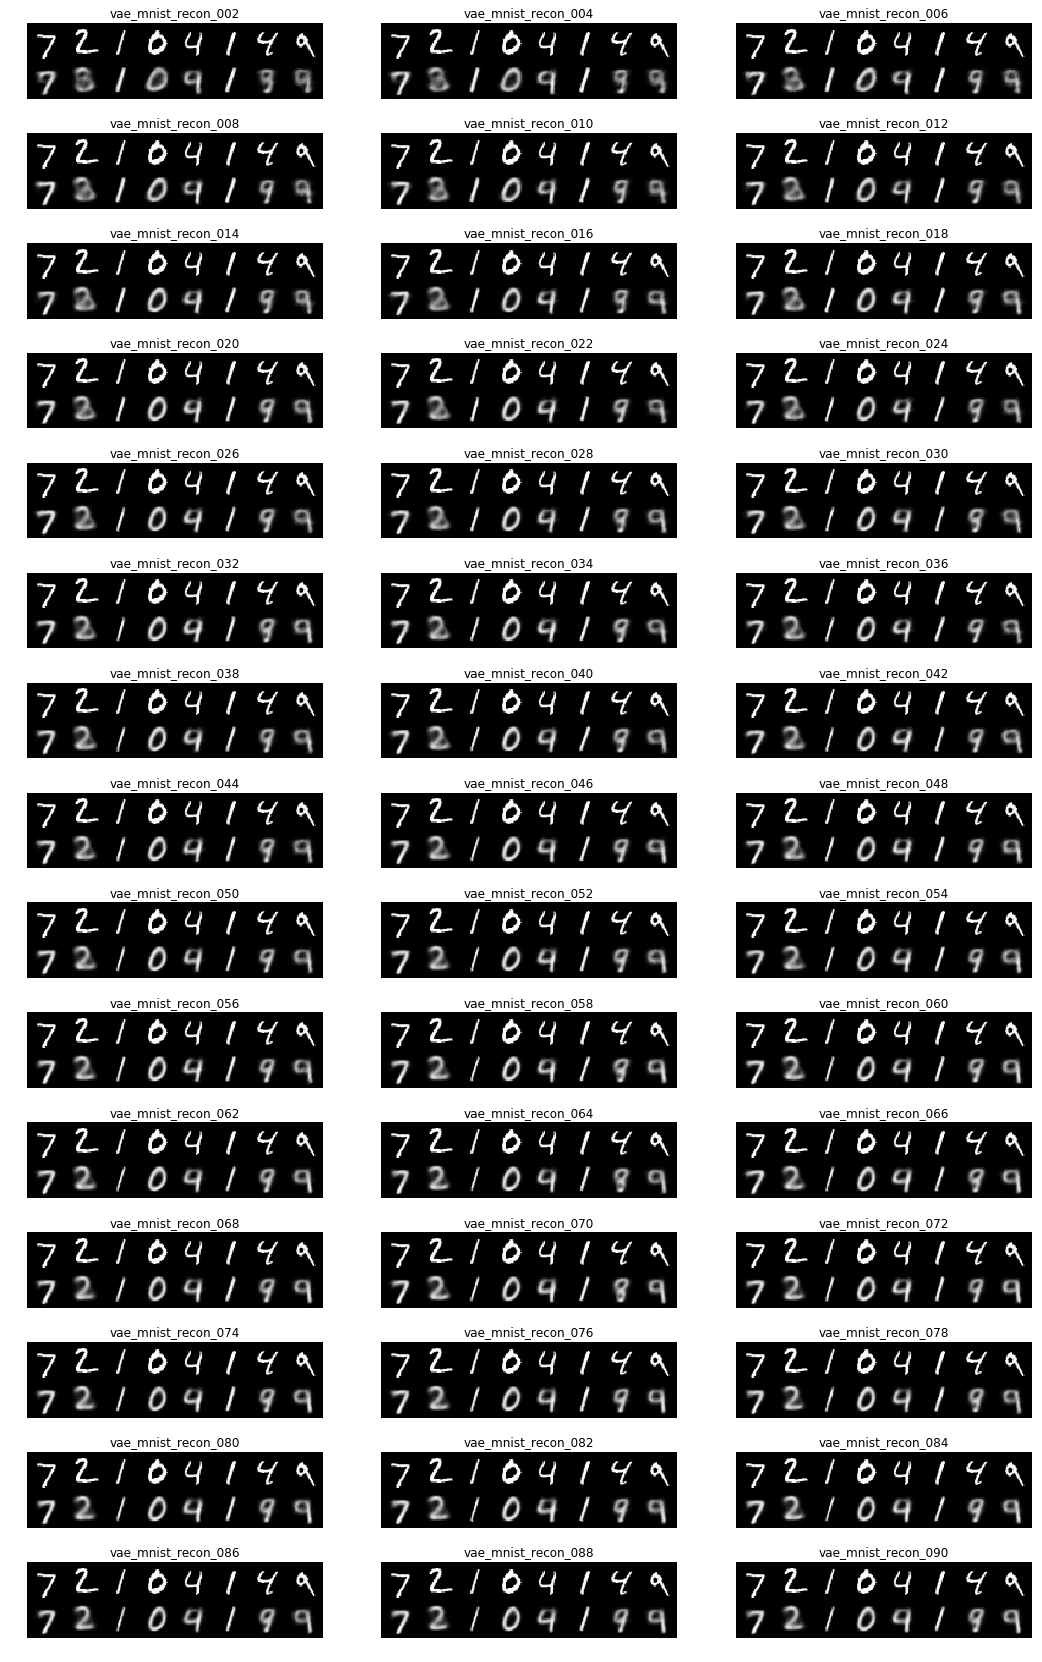

In [8]:
ifns = sorted(glob.glob(images_bfn + '*.png'))
n = len(ifns)
rows = np.ceil(n / 3)
fig = plt.figure(figsize=(18, 2*rows))
for i, fn in enumerate(ifns):
    title = os.path.basename(fn)[:-4]
    fig.add_subplot(rows, 3, i+1)
    img = plt.imread(fn)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title);
 

### Explorando o espaço da codificação

In [9]:
# display a 2D plot of the digit classes in the latent space
x_recon, x_encoded, _ = trainer.predict_loader(tst_loader)
y_test = [y for x, y in tst_loader.dataset]

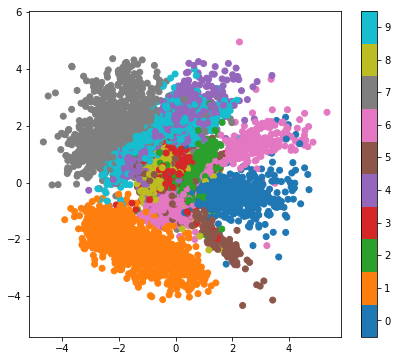

In [15]:
plt.figure(figsize=(7, 6))
plt.scatter(x_encoded.data.numpy()[:, 0], 
            x_encoded.data.numpy()[:, 1], c=y_test, cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

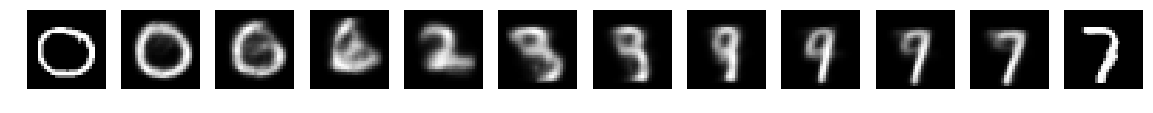

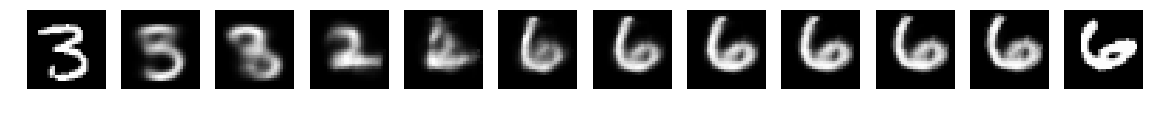

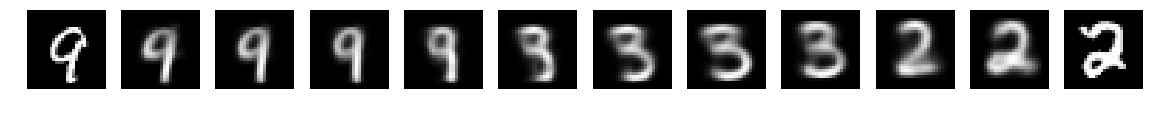

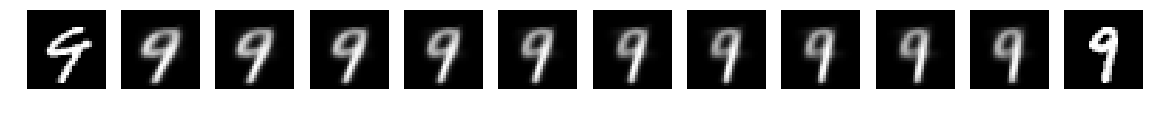

In [16]:
n = 10
for i in range(4):
    a = nr.randint(0, len(tst_loader.dataset))
    b = nr.randint(0, len(tst_loader.dataset))

    fig = plt.figure(figsize=(20, 2))

    img1, _ = tst_loader.dataset[a]
    img2, _ = tst_loader.dataset[b]
    img1 = img1.view(28, 28)
    img2 = img2.view(28, 28)
    
    plt.subplot(1, n+2, 1)
    plt.imshow(img1.numpy(), cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(1, n+2, n+2)
    plt.imshow(img2.numpy(), cmap=plt.cm.gray)
    plt.axis('off')

    images = Variable(torch.cat([img1, img2]).view(2, -1))
    if use_gpu:
        images = images.cuda()
    (code_a, code_b), _ = vae_net.encode(images)

    vec = code_b - code_a
    for i, q in enumerate(torch.linspace(0.0, 1.0, n)):
        v = code_a + q * vec
        v = torch.unsqueeze(v, 0)
        img = vae_net.decode(v)
        img = img.view(img1.shape)
        plt.subplot(1, n+2, i+2)
        plt.imshow(img.data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')